In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import random
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')

from dependence_metrics import kendallstau, utdc_at_threshold, utdc_cfg

/tmp/ipykernel_508/3902141566.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def pot(da,threshold,dim):
    
    assert (threshold>=0) & (threshold<1)
    
    return da.where(da>da.quantile(threshold,dim=dim))

def declustered_peaks(da,threshold,window_len,dim):
    #computes peaks above threshold of xr.DataArray and declusters them with a rolling window.
    
    peaks = pot(da,threshold,dim)
    
    return peaks.where(peaks==peaks.rolling({dim:window_len},center=True,min_periods=1).max(skipna=True))

def rolling_max(da,window_len,dim):
    return da.rolling({dim:window_len},center=True,min_periods=1).max()

Configure the bivariate sampling:

In [3]:
max_lag = 0 #days
declus_window_len = 1 #days
threshold = .98 #quantile

output_yrs = np.arange(1880,2100,20)
window_len=40 #may need to increase? indicate settings in output folder?

season = 'year' 
overwrite_output = True

Analyze surge & pr, looping over models & experiments:

In [4]:
sfcWind_dir = '/home/jovyan/CMIP6cf/output/timeseries/sfcWind_europe/'
pr_dir = '/home/jovyan/CMIP6cf/output/timeseries/pr_europe/'

source_ids = list(set(os.listdir(sfcWind_dir)) & set(os.listdir(pr_dir))) #intersection of models

for source_id in [k for k in source_ids if ~k.startswith('.')]: #loop over models
    
    sfcWind_path = os.path.join(sfcWind_dir,source_id)
    pr_path = os.path.join(pr_dir,source_id)
    
    sfcWind_exps = [s.split('_')[-1][0:-3] for s in os.listdir(sfcWind_path) if s.startswith('.')==False]
    pr_exps = [s.split('_')[-1][0:-3] for s in os.listdir(pr_path) if s.startswith('.')==False]
    
    experiment_ids = list(set(sfcWind_exps) & set(pr_exps))

    for experiment_id in experiment_ids: #loop over experiments
        #load data
        fn = fnmatch.filter(os.listdir(sfcWind_path),'*'+experiment_id+'*')[0]
        print('Processing file: '+fn)
        sfcWind_pr = xr.open_mfdataset((os.path.join(sfcWind_path,fn),os.path.join(pr_path,fn)),chunks={'member_id':1,'time':100000,'longitude':5})#.sel(longitude=np.arange(-25,11))
        
        #generate output paths & check if output already exists
        model_path = os.path.join('/home/jovyan/CMIP6cf/output/dependence/sfcWind_pr_europe/40yr_p98_lag0d_declus1d_ref1980',sfcWind_pr.source_id)
        output_fn = os.path.join(model_path,fn)

        if not os.path.exists(model_path):
            os.mkdir(model_path)

        if not overwrite_output: #if not overwriting existing output
            if os.path.exists(output_fn):
                print('Output already exists for this instance.')
                continue
        
        #construct time window indices
        if len(np.unique(sfcWind_pr.time.resample(time='1Y').count()))>1: #remove leap days so that each computation window has the same length
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                sfcWind_pr = sfcWind_pr.sel(time=~((sfcWind_pr.time.dt.month == 2) & (sfcWind_pr.time.dt.day == 29))) #^probably (hopefully) only has a small effect on the results
        
        #select DJF:
        days_in_year = int(sfcWind_pr.time.resample(time='1Y').count()[0])
        
        if window_len%2 !=0: #odd
            window_start_idx = days_in_year*(output_yrs-1850-int(np.floor(window_len/2)))
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        else: #even
            window_start_idx = days_in_year*(output_yrs-1850-int(window_len/2)+1)
            first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
        
        if np.max(first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:])>=len(sfcWind_pr.time):
            raise Exception('Windows exceed simulation length.')
            
        window_idx = xr.DataArray( #indices of windows
            data=first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:],
            dims=["time_in_window_idx","window"],
            coords=dict(
                time_in_window_idx=first_window_idx,
                window=output_yrs
            ),
        )
        
        for m,member in tqdm(enumerate(sfcWind_pr.member_id)): #loop over members to compute the dependence
            sfcWind_pr_mem = sfcWind_pr.sel(member_id=member).copy(deep=True).load()
   
            sfcWind_pr_wdws = sfcWind_pr_mem.isel(time=window_idx) #select windows
   
            data_is_complete = np.isfinite(sfcWind_pr_wdws.sfcWind).all(dim='time_in_window_idx') * np.isfinite(sfcWind_pr_wdws.pr).all(dim='time_in_window_idx')
            
            pr_hist_threshold = sfcWind_pr_wdws['pr'].sel(window=1980).quantile(threshold,dim='time_in_window_idx')
            sfcWind_hist_threshold = sfcWind_pr_wdws['sfcWind'].sel(window=1980).quantile(threshold,dim='time_in_window_idx')

            pr_peaks = sfcWind_pr_wdws['pr'].where(sfcWind_pr_wdws['pr']>pr_hist_threshold)
            sfcWind_peaks = sfcWind_pr_wdws['sfcWind'].where(sfcWind_pr_wdws['sfcWind']>sfcWind_hist_threshold)
            
            pr_peaks_declustered = pr_peaks.where(pr_peaks==pr_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            sfcWind_peaks_declustered = sfcWind_peaks.where(sfcWind_peaks==sfcWind_peaks.rolling({'time_in_window_idx':declus_window_len},center=True,min_periods=1).max(skipna=True))
            
            
            '''
            pr_peaks_declustered = declustered_peaks(sfcWind_pr_wdws['pr'],threshold,declus_window_len,dim='time_in_window_idx')
            sfcWind_peaks_declustered = declustered_peaks(sfcWind_pr_wdws['sfcWind'],threshold,declus_window_len,dim='time_in_window_idx')
            '''
            #count occurrences of peaks
            co_occurring = np.isfinite((rolling_max(pr_peaks_declustered,max_lag*2+1,dim='time_in_window_idx')*sfcWind_peaks_declustered))
            
            for month in np.arange(1,13):
                if month==1:
                    num_co_occurring_pmonth = co_occurring.where(co_occurring.time.dt.month==month).sum(dim='time_in_window_idx')
                    num_pr_peaks_pmonth = np.isfinite(pr_peaks_declustered.where(pr_peaks_declustered.time.dt.month==month)).sum(dim='time_in_window_idx')
                    num_sfcWind_peaks_pmonth = np.isfinite(sfcWind_peaks_declustered.where(sfcWind_peaks_declustered.time.dt.month==month)).sum(dim='time_in_window_idx')
                else:
                    num_co_occurring_pmonth = xr.concat((num_co_occurring_pmonth,co_occurring.where(co_occurring.time.dt.month==month).sum(dim='time_in_window_idx')),dim='month')
                    num_pr_peaks_pmonth = xr.concat((num_pr_peaks_pmonth,np.isfinite(pr_peaks_declustered.where(pr_peaks_declustered.time.dt.month==month)).sum(dim='time_in_window_idx')),dim='month')
                    num_sfcWind_peaks_pmonth = xr.concat((num_sfcWind_peaks_pmonth,np.isfinite(sfcWind_peaks_declustered.where(sfcWind_peaks_declustered.time.dt.month==month)).sum(dim='time_in_window_idx')),dim='month')
                    
            num_co_occurring_pmonth = num_co_occurring_pmonth.assign_coords({'month':np.arange(1,13)})                             
            num_pr_peaks_pmonth = num_pr_peaks_pmonth.assign_coords({'month':np.arange(1,13)})       
            num_sfcWind_peaks_pmonth = num_sfcWind_peaks_pmonth.assign_coords({'month':np.arange(1,13)})       
            
            #dependence_mem = xr.concat([ktau_pr_cdon_sfcWind,ktau_sfcWind_cdon_pr,ktau_both_peaks],dim='extreme_variate').to_dataset(name='ktau')
                
            dependence_mem = num_co_occurring_pmonth.to_dataset(name='num_co_occurring')
            dependence_mem['num_pr_peaks'] = num_pr_peaks_pmonth
            dependence_mem['num_sfcWind_peaks'] = num_sfcWind_peaks_pmonth
            
            
            #store thresholds
            dependence_mem['sfcWind_thresholds_annual'] = sfcWind_pr_wdws['sfcWind'].quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            dependence_mem['pr_thresholds_annual'] = sfcWind_pr_wdws['pr'].quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            
            dependence_mem['sfcWind_thresholds_djf'] = sfcWind_pr_wdws['sfcWind'].where(np.mod(sfcWind_pr_wdws.time.dt.month,12)<3).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            dependence_mem['pr_thresholds_djf'] = sfcWind_pr_wdws['pr'].where(np.mod(sfcWind_pr_wdws.time.dt.month,12)<3).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            
            dependence_mem['sfcWind_thresholds_mam'] = sfcWind_pr_wdws['sfcWind'].where((np.mod(sfcWind_pr_wdws.time.dt.month,12)>2) & (np.mod(sfcWind_pr_wdws.time.dt.month,12)<6)).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            dependence_mem['pr_thresholds_mam'] = sfcWind_pr_wdws['pr'].where((np.mod(sfcWind_pr_wdws.time.dt.month,12)>2) & (np.mod(sfcWind_pr_wdws.time.dt.month,12)<6)).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            
            dependence_mem['sfcWind_thresholds_jja'] = sfcWind_pr_wdws['sfcWind'].where((np.mod(sfcWind_pr_wdws.time.dt.month,12)>5) & (np.mod(sfcWind_pr_wdws.time.dt.month,12)<9)).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            dependence_mem['pr_thresholds_jja'] = sfcWind_pr_wdws['pr'].where((np.mod(sfcWind_pr_wdws.time.dt.month,12)>5) & (np.mod(sfcWind_pr_wdws.time.dt.month,12)<9)).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            
            dependence_mem['sfcWind_thresholds_son'] = sfcWind_pr_wdws['sfcWind'].where((np.mod(sfcWind_pr_wdws.time.dt.month,12)>8) & (np.mod(sfcWind_pr_wdws.time.dt.month,12)<12)).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            dependence_mem['pr_thresholds_son'] = sfcWind_pr_wdws['pr'].where((np.mod(sfcWind_pr_wdws.time.dt.month,12)>8) & (np.mod(sfcWind_pr_wdws.time.dt.month,12)<12)).quantile(np.arange(.9,1,.01),dim='time_in_window_idx')
            dependence_mem['complete_window'] = data_is_complete #store where windows miss data
            
            
            dependence_mem = dependence_mem.expand_dims(dim={"member_id": 1}) #add coordinates & dimensions
            #dependence_mem = dependence_mem.assign_coords({'extreme_variate':['sfcWind','pr','both'],'statistic':['coef','p'],'estimator':['cfg','.95']})
            
            if m==0: #concatenate results over member_id's
                dependence = dependence_mem
            else:
                dependence = xr.concat((dependence,dependence_mem),dim='member_id')    
            
            dependence.attrs = sfcWind_pr.attrs #keep original attributes and add information on the extremes analysis
            dependence.attrs['window_length'] = str(window_len)
            dependence.attrs['declustering'] = 'Rolling window of '+str(declus_window_len)+' days'
            dependence.attrs['allowed_lag'] = str(max_lag)
            
            #store for all members of this model & experiment
            dependence.to_netcdf(output_fn,mode='w')
            dependence.close()
            

Processing file: MRI-ESM2-0_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: MRI-ESM2-0_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: EC-Earth3_gr_day_ssp245.nc


0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/

Processing file: EC-Earth3_gr_day_ssp585.nc


0it [00:00, ?it/s]

/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1583: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/srv/conda/envs/notebook/lib/python3.10/site-packages/numpy/

Processing file: NorESM2-MM_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: NorESM2-MM_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: GFDL-CM4_gr1_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: GFDL-CM4_gr1_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: TaiESM1_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: TaiESM1_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: CESM2_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: CESM2_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: MPI-ESM1-2-HR_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: MPI-ESM1-2-HR_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: MIROC6_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: MIROC6_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: GFDL-ESM4_gr1_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: GFDL-ESM4_gr1_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: CMCC-CM2-SR5_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: CMCC-CM2-SR5_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: CESM2-WACCM_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: CESM2-WACCM_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: CMCC-ESM2_gn_day_ssp245.nc


0it [00:00, ?it/s]

Processing file: CMCC-ESM2_gn_day_ssp585.nc


0it [00:00, ?it/s]

Processing file: HadGEM3-GC31-MM_gn_day_ssp585.nc


0it [00:00, ?it/s]

In [12]:
dependence

<xarray.Dataset>
Dimensions:                    (member_id: 2, longitude: 51, latitude: 34,
                                window: 11, quantile: 10, month: 12)
Coordinates:
  * member_id                  (member_id) <U9 'r11i1p1f1' 'r4i1p1f1'
  * longitude                  (longitude) int64 -30 -29 -28 -27 ... 17 18 19 20
  * latitude                   (latitude) int64 35 36 37 38 39 ... 65 66 67 68
  * window                     (window) int64 1880 1900 1920 ... 2040 2060 2080
  * quantile                   (quantile) float64 0.9 0.91 0.92 ... 0.98 0.99
  * month                      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/13)
    num_co_occurring           (member_id, month, window, latitude, longitude) float64 ...
    num_pr_peaks               (member_id, month, window, latitude, longitude) int64 ...
    num_sfcWind_peaks          (member_id, month, window, latitude, longitude) int64 ...
    sfcWind_thresholds_annual  (member_id, quantile, window, latitude, longitude) float64 ...
    pr_thresholds_annual       (member_id, quantile, window, latitude, longitude) float64 ...
    sfcWind_thresholds_djf     (member_id, quantile, window, latitude, longitude) float64 ...
    ...                         ...
    sfcWind_thresholds_mam     (member_id, quantile, window, latitude, longitude) float64 ...
    pr_thresholds_mam          (member_id, quantile, window, latitude, longitude) float64 ...
    sfcWind_thresholds_jja     (member_id, quantile, window, latitude, longitude) float64 ...
    pr_thresholds_jja          (member_id, quantile, window, latitude, longitude) float64 ...
    sfcWind_thresholds_son     (member_id, quantile, window, latitude, longitude) float64 ...
    pr_thresholds_son          (member_id, quantile, window, latitude, longitude) float64 ...
Attributes: (12/66)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             674885.0
    branch_time_in_parent:            219000.0
    case_id:                          972
    ...                               ...
    intake_esm_dataset_key:           CMIP.NCAR.CESM2.historical.r11i1p1f1.da...
    original_key:                     CESM2.gn.historical.day.r11i1p1f1
    regrid_method:                    bilinear
    window_length:                    40
    declustering:                     Rolling window of 1 days
    allowed_lag:                      0

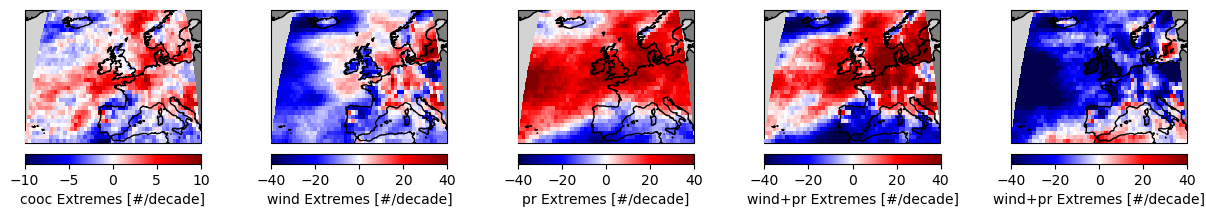

In [44]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_cooc = dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)
sc=(.25*diff_cooc.mean(dim='member_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='cooc Extremes [#/decade]')

ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_pr = dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=1980)
sc=(.25*diff_pr.mean(dim='member_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='wind Extremes [#/decade]')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_sfcWind = dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)
sc=(.25*diff_sfcWind.mean(dim='member_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='pr Extremes [#/decade]')



ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_sfcWind = dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)
sc=(.25*(diff_sfcWind+diff_pr).mean(dim='member_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='wind+pr Extremes [#/decade]')


ax = plt.subplot(gs[0,4],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_sfcWind = dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)
sc=(.25*(diff_cooc-diff_sfcWind+diff_pr).mean(dim='member_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='wind+pr Extremes [#/decade]')


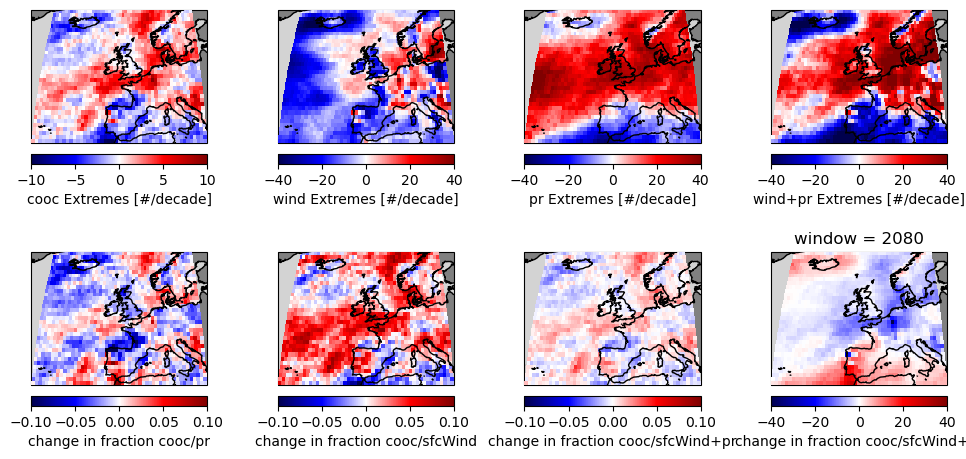

In [72]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,5)
gs.update(wspace=.4,hspace=.1)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_cooc =(dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980) )
sc=(.25*diff_cooc.mean(dim='member_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='cooc Extremes [#/decade]')

ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_sfcWind = (dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=1980))
sc=(.25*diff_sfcWind.mean(dim='member_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='wind Extremes [#/decade]')

ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_pr = (dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980))
sc=(.25*diff_pr.mean(dim='member_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='pr Extremes [#/decade]')



ax = plt.subplot(gs[0,3],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_pr = dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)
diff_sfcWind = dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=1980)
diff_cooc = dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)

sc=(.25*(diff_sfcWind+diff_pr).mean(dim='member_id')).plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='wind+pr Extremes [#/decade]')


ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_pr = dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)
diff_sfcWind = dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=1980)
diff_cooc = dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)

diff_frac_pr = (dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)/dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080)) - (dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)/dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980))
sc=diff_frac_pr.mean(dim='member_id').plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='change in fraction cooc/pr')

ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_frac_sfcWind = (dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)/dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=2080)) - (dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)/dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=1980))
sc=diff_frac_sfcWind.mean(dim='member_id').plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='change in fraction cooc/sfcWind')



ax = plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

diff_frac_both = (dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)/(dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=2080)+dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080))) - (dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)/(dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=1980)+dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)))
sc=diff_frac_both.mean(dim='member_id').plot(cmap='seismic',vmin=-.1,vmax=.1,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='change in fraction cooc/sfcWind+pr')


ax = plt.subplot(gs[1,3],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

#k is new fraction times old total
k = (dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)/(dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=2080)+dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=2080))) * (dependence.num_sfcWind_peaks.sum(dim='month',skipna=False).sel(window=1980)+dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)) - dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)
sc=k.mean(dim='member_id').plot(cmap='seismic',vmin=-40,vmax=40,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
#sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='change in fraction cooc/sfcWind+pr')


### CAN I DO OLD FRACTION TIMES NEW NUMBERS, NEW FRACTION TIMES OLD NUMBERS TYPE OF THING TO DECOMPOSE?

In [56]:
dependence.num_pr_peaks.sum(dim='month',skipna=False).sel(window=1980)/dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)

<xarray.DataArray (member_id: 2, latitude: 34, longitude: 51)>
array([[[ 7.68421053,  7.12195122,  7.12195122, ...,  7.68421053,
          9.125     ,  8.34285714],
        [ 8.11111111,  8.34285714,  7.89189189, ...,  7.68421053,
          8.84848485,  8.34285714],
        [10.42857143,  8.11111111,  7.89189189, ...,  6.95238095,
          8.34285714,  8.34285714],
        ...,
        [ 5.12280702,  6.21276596,  7.48717949, ..., 15.36842105,
         13.27272727, 13.27272727],
        [ 5.03448276,  6.21276596,  6.95238095, ..., 12.16666667,
         16.22222222, 13.9047619 ],
        [ 4.63492063,  5.12280702,  5.30909091, ...,  7.48717949,
         10.42857143, 19.46666667]],

       [[ 8.34285714,  7.68421053,  6.95238095, ...,  7.12195122,
          6.48888889,  7.12195122],
        [ 8.34285714,  9.125     ,  7.3       , ..., 10.06896552,
          8.84848485,  7.12195122],
        [ 9.125     ,  9.125     ,  7.68421053, ...,  9.125     ,
          8.34285714,  7.68421053],
        ...,
        [ 5.7254902 ,  8.58823529, 10.81481481, ..., 14.6       ,
         17.17647059, 19.46666667],
        [ 5.50943396,  6.63636364,  7.68421053, ..., 17.17647059,
         26.54545455, 32.44444444],
        [ 7.68421053,  8.58823529, 10.42857143, ...,  7.12195122,
         10.81481481, 18.25      ]]])
Coordinates:
  * member_id  (member_id) <U9 'r11i1p1f1' 'r4i1p1f1'
  * longitude  (longitude) int64 -30 -29 -28 -27 -26 -25 ... 15 16 17 18 19 20
  * latitude   (latitude) int64 35 36 37 38 39 40 41 42 ... 62 63 64 65 66 67 68
    window     int64 1980

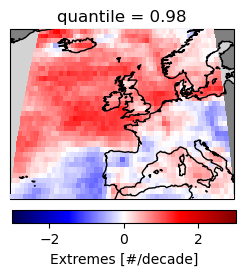

In [24]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

#sc=(.25*(dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
sc=((dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.sfcWind_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-3,vmax=3,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')


#ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
#ax.annotate('ad'+')',(.05,.9),xycoords='axes fraction',fontweight='bold')


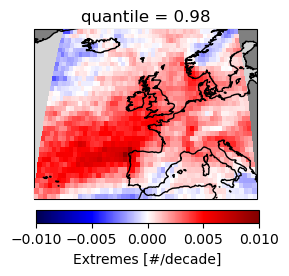

In [27]:
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig=plt.figure(figsize=(15,6)) #generate figure  
gs = fig.add_gridspec(2,4)
gs.update(wspace=.4,hspace=.1)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

#sc=(.25*(dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=2080)-dependence.num_co_occurring.sum(dim='month',skipna=False).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-10,vmax=10,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
sc=((dependence.pr_thresholds_djf.isel(quantile=8).sel(window=2080)-dependence.pr_thresholds_djf.isel(quantile=8).sel(window=1980)).mean(dim='member_id')-(dependence.pr_thresholds_jja.isel(quantile=8).sel(window=2080)-dependence.pr_thresholds_jja.isel(quantile=8).sel(window=1980)).mean(dim='member_id')).plot(cmap='seismic',vmin=-.01,vmax=.01,transform=ccrs.PlateCarree(),zorder=3,ax=ax,add_colorbar=False)
ax.coastlines(zorder=5)
#sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=.25*ssp_ds_present.num_co_occurring.mean(dim='member_id').mean(dim='source_id'),cmap='Reds',vmin=0,vmax=30,s=20,transform=ccrs.PlateCarree(),zorder=3)
#ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='Extremes [#/decade]')


#ax.annotate(['SSP2-4.5','SSP5-8.5'][s],(-.2,.35),xycoords='axes fraction',rotation=90)
#ax.annotate('ad'+')',(.05,.9),xycoords='axes fraction',fontweight='bold')
